<a href="https://colab.research.google.com/github/KishoreRam07/DWDM/blob/main/Team_yolo_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install ultralytics roboflow opencv-python



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 921.5/921.5 kB 22.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.1/83.1 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 66.8/66.8 kB 5.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 56.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 56.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20

In [2]:
!git clone https://github.com/PerceptiLabs/Pill-Defects.git


Cloning into 'Pill-Defects'...
remote: Enumerating objects: 378, done.
remote: Counting objects: 100% (378/378), done.
remote: Compressing objects: 100% (372/372), done.
remote: Total 378 (delta 7), reused 373 (delta 5), pack-reused 0 (from 0)
Receiving objects: 100% (378/378), 28.72 MiB | 22.29 MiB/s, done.
Resolving deltas: 100% (7/7), done.


In [3]:
%cd Pill-Defects


/content/Pill-Defects


In [10]:
import os
import pandas as pd
import cv2

# Load dataset
df = pd.read_csv("data.csv")  # Ensure this file contains image paths & labels

# Define class mapping
class_mapping = {"defect": 0, "normal": 1}

# Create directories
os.makedirs("yolo_dataset/images/train", exist_ok=True)
os.makedirs("yolo_dataset/images/val", exist_ok=True)
os.makedirs("yolo_dataset/labels/train", exist_ok=True)
os.makedirs("yolo_dataset/labels/val", exist_ok=True)

# Split dataset (80% train, 20% val)
train_df = df.sample(frac=0.8, random_state=42)
val_df = df.drop(train_df.index)

def convert_to_yolo(df, split):
    for _, row in df.iterrows():
        image_path = row["images"]
        label = class_mapping[row["labels"]]

        # Read image
        img = cv2.imread(image_path)
        h, w, _ = img.shape

        # Normalize bbox (if bbox data exists, replace placeholder values)
        x_center, y_center, width, height = 0.5, 0.5, 1.0, 1.0  # Placeholder

        # Save label
        label_file = f"yolo_dataset/labels/{split}/{os.path.basename(image_path).replace('.png', '.txt')}"
        with open(label_file, "w") as f:
            f.write(f"{label} {x_center} {y_center} {width} {height}\n")

        # Move image
        os.system(f"cp {image_path} yolo_dataset/images/{split}/")

# Convert train and val datasets
convert_to_yolo(train_df, "train")
convert_to_yolo(val_df, "val")

# Create YOLOv8 data.yaml file
with open("yolo_dataset/data.yaml", "w") as f:
    f.write("""
    path: yolo_dataset
    train: images/train
    val: images/val
    nc: 2
    names: ["defect", "normal"]
    """)


In [11]:
import os

# Get the absolute dataset path
dataset_path = os.path.abspath("yolo_dataset")

# Create YOLOv8 data.yaml with absolute paths
with open("yolo_dataset/data.yaml", "w") as f:
    f.write(f"""
path: {dataset_path}
train: {dataset_path}/images/train
val: {dataset_path}/images/val
nc: 2
names: ["defect", "normal"]
    """)


In [12]:
from ultralytics import YOLO

# Load model
model = YOLO("yolov8n.pt")  # Use YOLOv8n (small) model

# Train model
model.train(data="yolo_dataset/data.yaml", epochs=50, imgsz=640, batch=16, device=0)


Ultralytics 8.3.78 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=yolo_dataset/data.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train4, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True,

100%|██████████| 755k/755k [00:00<00:00, 17.6MB/s]


Overriding model.yaml nc=80 with nc=2

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 96.3MB/s]


AMP: checks passed ✅


train: Scanning /content/Pill-Defects/yolo_dataset/labels/train... 208 images, 0 backgrounds, 0 corrupt: 100%|██████████| 208/208 [00:00<00:00, 1976.91it/s]

train: New cache created: /content/Pill-Defects/yolo_dataset/labels/train.cache


albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/Pill-Defects/yolo_dataset/labels/val... 52 images, 0 backgrounds, 0 corrupt: 100%|██████████| 52/52 [00:00<00:00, 549.67it/s]

val: New cache created: /content/Pill-Defects/yolo_dataset/labels/val.cache


Plotting labels to runs/detect/train4/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train4
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      2.06G      1.942      3.024       2.86         46        640: 100%|██████████| 13/13 [00:05<00:00,  2.24it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:02<00:00,  1.14s/it]

                   all         52         52    0.00333          1      0.465      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      1.99G      0.643      1.922      1.328         44        640: 100%|██████████| 13/13 [00:03<00:00,  4.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.12it/s]

                   all         52         52    0.00374      0.964     0.0637     0.0121



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      1.99G     0.4676      1.575      1.168         51        640: 100%|██████████| 13/13 [00:03<00:00,  4.20it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.40it/s]

                   all         52         52        0.5          1      0.601      0.357



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50         2G     0.4035      1.426        1.1         43        640: 100%|██████████| 13/13 [00:03<00:00,  4.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.42it/s]

                   all         52         52      0.477      0.767      0.591      0.263



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      1.99G     0.3543      1.223      1.063         46        640: 100%|██████████| 13/13 [00:02<00:00,  4.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.61it/s]

                   all         52         52      0.992        0.5      0.541      0.278



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50         2G     0.3308      1.062      1.029         49        640: 100%|██████████| 13/13 [00:03<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.66it/s]

                   all         52         52      0.979      0.429      0.481      0.435



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50         2G     0.3154      1.004      1.019         48        640: 100%|██████████| 13/13 [00:02<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.81it/s]

                   all         52         52     0.0764     0.0595     0.0349     0.0142



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      1.99G     0.2729     0.9035     0.9856         48        640: 100%|██████████| 13/13 [00:02<00:00,  4.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.74it/s]


                   all         52         52      0.731        0.5      0.266      0.233

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50         2G     0.2887     0.9093      1.013         46        640: 100%|██████████| 13/13 [00:03<00:00,  3.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.09it/s]

                   all         52         52      0.918      0.911      0.979      0.898



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      1.99G     0.2695     0.8003     0.9824         54        640: 100%|██████████| 13/13 [00:02<00:00,  4.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.01it/s]

                   all         52         52      0.996          1      0.995       0.93



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      1.99G     0.2478     0.7397     0.9709         47        640: 100%|██████████| 13/13 [00:02<00:00,  4.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.65it/s]

                   all         52         52       0.98      0.982      0.995       0.99



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      1.99G     0.2757     0.7321     0.9812         42        640: 100%|██████████| 13/13 [00:02<00:00,  4.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.89it/s]

                   all         52         52      0.748      0.572       0.42      0.389



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50         2G     0.2364     0.6961     0.9675         49        640: 100%|██████████| 13/13 [00:02<00:00,  4.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.83it/s]

                   all         52         52      0.713      0.974      0.746      0.716



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      1.99G     0.2211     0.6702      0.947         52        640: 100%|██████████| 13/13 [00:03<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.99it/s]

                   all         52         52      0.982      0.985      0.995      0.975



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      1.99G     0.2082     0.6272     0.9538         45        640: 100%|██████████| 13/13 [00:02<00:00,  4.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.99it/s]

                   all         52         52      0.726      0.785       0.83      0.828



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      1.99G     0.1961     0.5984     0.9547         48        640: 100%|██████████| 13/13 [00:02<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.65it/s]

                   all         52         52      0.831      0.893      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50         2G     0.2009     0.5295     0.9327         54        640: 100%|██████████| 13/13 [00:03<00:00,  3.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.90it/s]

                   all         52         52      0.996          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50         2G     0.1949     0.5435     0.9369         43        640: 100%|██████████| 13/13 [00:02<00:00,  4.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.06it/s]

                   all         52         52      0.998          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      1.99G      0.194     0.5295     0.9371         48        640: 100%|██████████| 13/13 [00:02<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.06it/s]

                   all         52         52      0.765      0.987      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      1.99G     0.1957     0.5077     0.9462         49        640: 100%|██████████| 13/13 [00:03<00:00,  4.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.19it/s]

                   all         52         52      0.765       0.77      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50         2G     0.1841     0.5145     0.9318         43        640: 100%|██████████| 13/13 [00:03<00:00,  4.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.18it/s]

                   all         52         52      0.859      0.903      0.995      0.969



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      1.99G     0.1701     0.4567     0.9261         50        640: 100%|██████████| 13/13 [00:03<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.10it/s]

                   all         52         52      0.888      0.954      0.995      0.976



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      1.99G     0.1598     0.4932     0.9311         48        640: 100%|██████████| 13/13 [00:03<00:00,  4.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.26it/s]

                   all         52         52      0.996          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      1.99G     0.1639     0.4697     0.9255         55        640: 100%|██████████| 13/13 [00:02<00:00,  4.36it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.26it/s]

                   all         52         52      0.997          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50         2G     0.1536     0.4405     0.9236         51        640: 100%|██████████| 13/13 [00:03<00:00,  3.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.70it/s]

                   all         52         52      0.996          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      1.99G     0.1573     0.4755     0.9242         45        640: 100%|██████████| 13/13 [00:03<00:00,  4.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.11it/s]

                   all         52         52      0.998          1      0.995      0.992



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      1.99G     0.1375     0.3834     0.9228         44        640: 100%|██████████| 13/13 [00:02<00:00,  4.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.95it/s]

                   all         52         52      0.998          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      1.99G     0.1405     0.4227     0.9415         45        640: 100%|██████████| 13/13 [00:03<00:00,  4.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.07it/s]

                   all         52         52      0.998          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50         2G       0.13     0.3914     0.9177         44        640: 100%|██████████| 13/13 [00:02<00:00,  4.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.01it/s]

                   all         52         52      0.997          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      1.99G     0.1305     0.3923     0.9177         47        640: 100%|██████████| 13/13 [00:03<00:00,  3.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.46it/s]

                   all         52         52      0.998          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50         2G     0.1332     0.3863      0.919         46        640: 100%|██████████| 13/13 [00:02<00:00,  4.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.00it/s]

                   all         52         52      0.998          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      1.99G     0.1244     0.3617     0.9146         41        640: 100%|██████████| 13/13 [00:03<00:00,  4.29it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.82it/s]

                   all         52         52      0.998          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50         2G     0.1177     0.3488      0.924         49        640: 100%|██████████| 13/13 [00:03<00:00,  3.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.83it/s]

                   all         52         52      0.998          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      1.99G      0.117     0.3368     0.9083         47        640: 100%|██████████| 13/13 [00:02<00:00,  4.49it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.82it/s]

                   all         52         52      0.998          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      1.99G     0.1103     0.3091     0.8941         48        640: 100%|██████████| 13/13 [00:02<00:00,  4.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:01<00:00,  1.84it/s]

                   all         52         52      0.997          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      1.99G     0.1094     0.2931     0.9158         51        640: 100%|██████████| 13/13 [00:03<00:00,  4.12it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.15it/s]

                   all         52         52      0.877      0.966      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50         2G     0.1084     0.3068     0.9013         52        640: 100%|██████████| 13/13 [00:02<00:00,  4.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.11it/s]

                   all         52         52      0.995          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      1.99G     0.1164     0.3081     0.9066         57        640: 100%|██████████| 13/13 [00:03<00:00,  3.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.34it/s]

                   all         52         52      0.998          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      1.99G     0.1132     0.3156     0.9138         48        640: 100%|██████████| 13/13 [00:02<00:00,  4.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.65it/s]

                   all         52         52      0.998          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      1.99G     0.1048       0.28     0.8952         41        640: 100%|██████████| 13/13 [00:02<00:00,  4.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.44it/s]

                   all         52         52      0.998          1      0.995      0.995


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      1.99G    0.08427     0.5137     0.9138         16        640: 100%|██████████| 13/13 [00:05<00:00,  2.38it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.66it/s]

                   all         52         52      0.998          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      1.99G    0.07094     0.3048     0.9272         16        640: 100%|██████████| 13/13 [00:02<00:00,  4.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.84it/s]

                   all         52         52      0.998          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      1.99G    0.08051      0.297     0.9402         16        640: 100%|██████████| 13/13 [00:03<00:00,  3.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.55it/s]

                   all         52         52      0.998          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      1.99G    0.06346     0.2689     0.9226         16        640: 100%|██████████| 13/13 [00:02<00:00,  4.37it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.16it/s]

                   all         52         52      0.998          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      1.99G    0.05896     0.2661     0.9219         16        640: 100%|██████████| 13/13 [00:02<00:00,  4.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.80it/s]

                   all         52         52      0.998          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      1.99G    0.05778     0.2746     0.9025         16        640: 100%|██████████| 13/13 [00:03<00:00,  3.32it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.58it/s]

                   all         52         52      0.998          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      1.99G    0.05438     0.2241     0.9135         16        640: 100%|██████████| 13/13 [00:02<00:00,  4.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.35it/s]

                   all         52         52      0.998          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      1.99G    0.05382     0.2188     0.9073         16        640: 100%|██████████| 13/13 [00:02<00:00,  4.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.28it/s]

                   all         52         52      0.998          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50         2G    0.05085     0.2467     0.8925         16        640: 100%|██████████| 13/13 [00:03<00:00,  3.98it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  2.87it/s]

                   all         52         52      0.998          1      0.995      0.995



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      1.99G    0.04457     0.2044     0.9289         16        640: 100%|██████████| 13/13 [00:02<00:00,  4.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.09it/s]

                   all         52         52      0.998          1      0.995      0.995



50 epochs completed in 0.069 hours.
Optimizer stripped from runs/detect/train4/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train4/weights/best.pt, 6.2MB

Validating runs/detect/train4/weights/best.pt...
Ultralytics 8.3.78 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 2/2 [00:00<00:00,  3.05it/s]


                   all         52         52      0.998          1      0.995      0.995
                defect         24         24      0.998          1      0.995      0.995
                normal         28         28      0.998          1      0.995      0.995
Speed: 0.2ms preprocess, 2.2ms inference, 0.0ms loss, 2.1ms postprocess per image
Results saved to runs/detect/train4


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x780d517d9590>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04804

In [13]:
model.val()


Ultralytics 8.3.78 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,038 parameters, 0 gradients, 8.1 GFLOPs


val: Scanning /content/Pill-Defects/yolo_dataset/labels/val.cache... 52 images, 0 backgrounds, 0 corrupt: 100%|██████████| 52/52 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:02<00:00,  1.98it/s]


                   all         52         52      0.998          1      0.995      0.995
                defect         24         24      0.998          1      0.995      0.995
                normal         28         28      0.998          1      0.995      0.995
Speed: 13.5ms preprocess, 8.7ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to runs/detect/train42


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x780e29bc54d0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04804

In [26]:
import os
print(os.listdir("runs/detect/train4"))


['train_batch1.jpg', 'results.csv', 'results.png', 'weights', 'val_batch0_pred.jpg', 'confusion_matrix_normalized.png', 'R_curve.png', 'train_batch520.jpg', 'val_batch1_pred.jpg', 'train_batch0.jpg', 'labels.jpg', 'F1_curve.png', 'P_curve.png', 'args.yaml', 'train_batch522.jpg', 'PR_curve.png', 'val_batch1_labels.jpg', 'train_batch2.jpg', 'val_batch0_labels.jpg', 'labels_correlogram.jpg', 'events.out.tfevents.1740150481.8dcc2b9b3179.362.0', 'confusion_matrix.png', 'train_batch521.jpg']


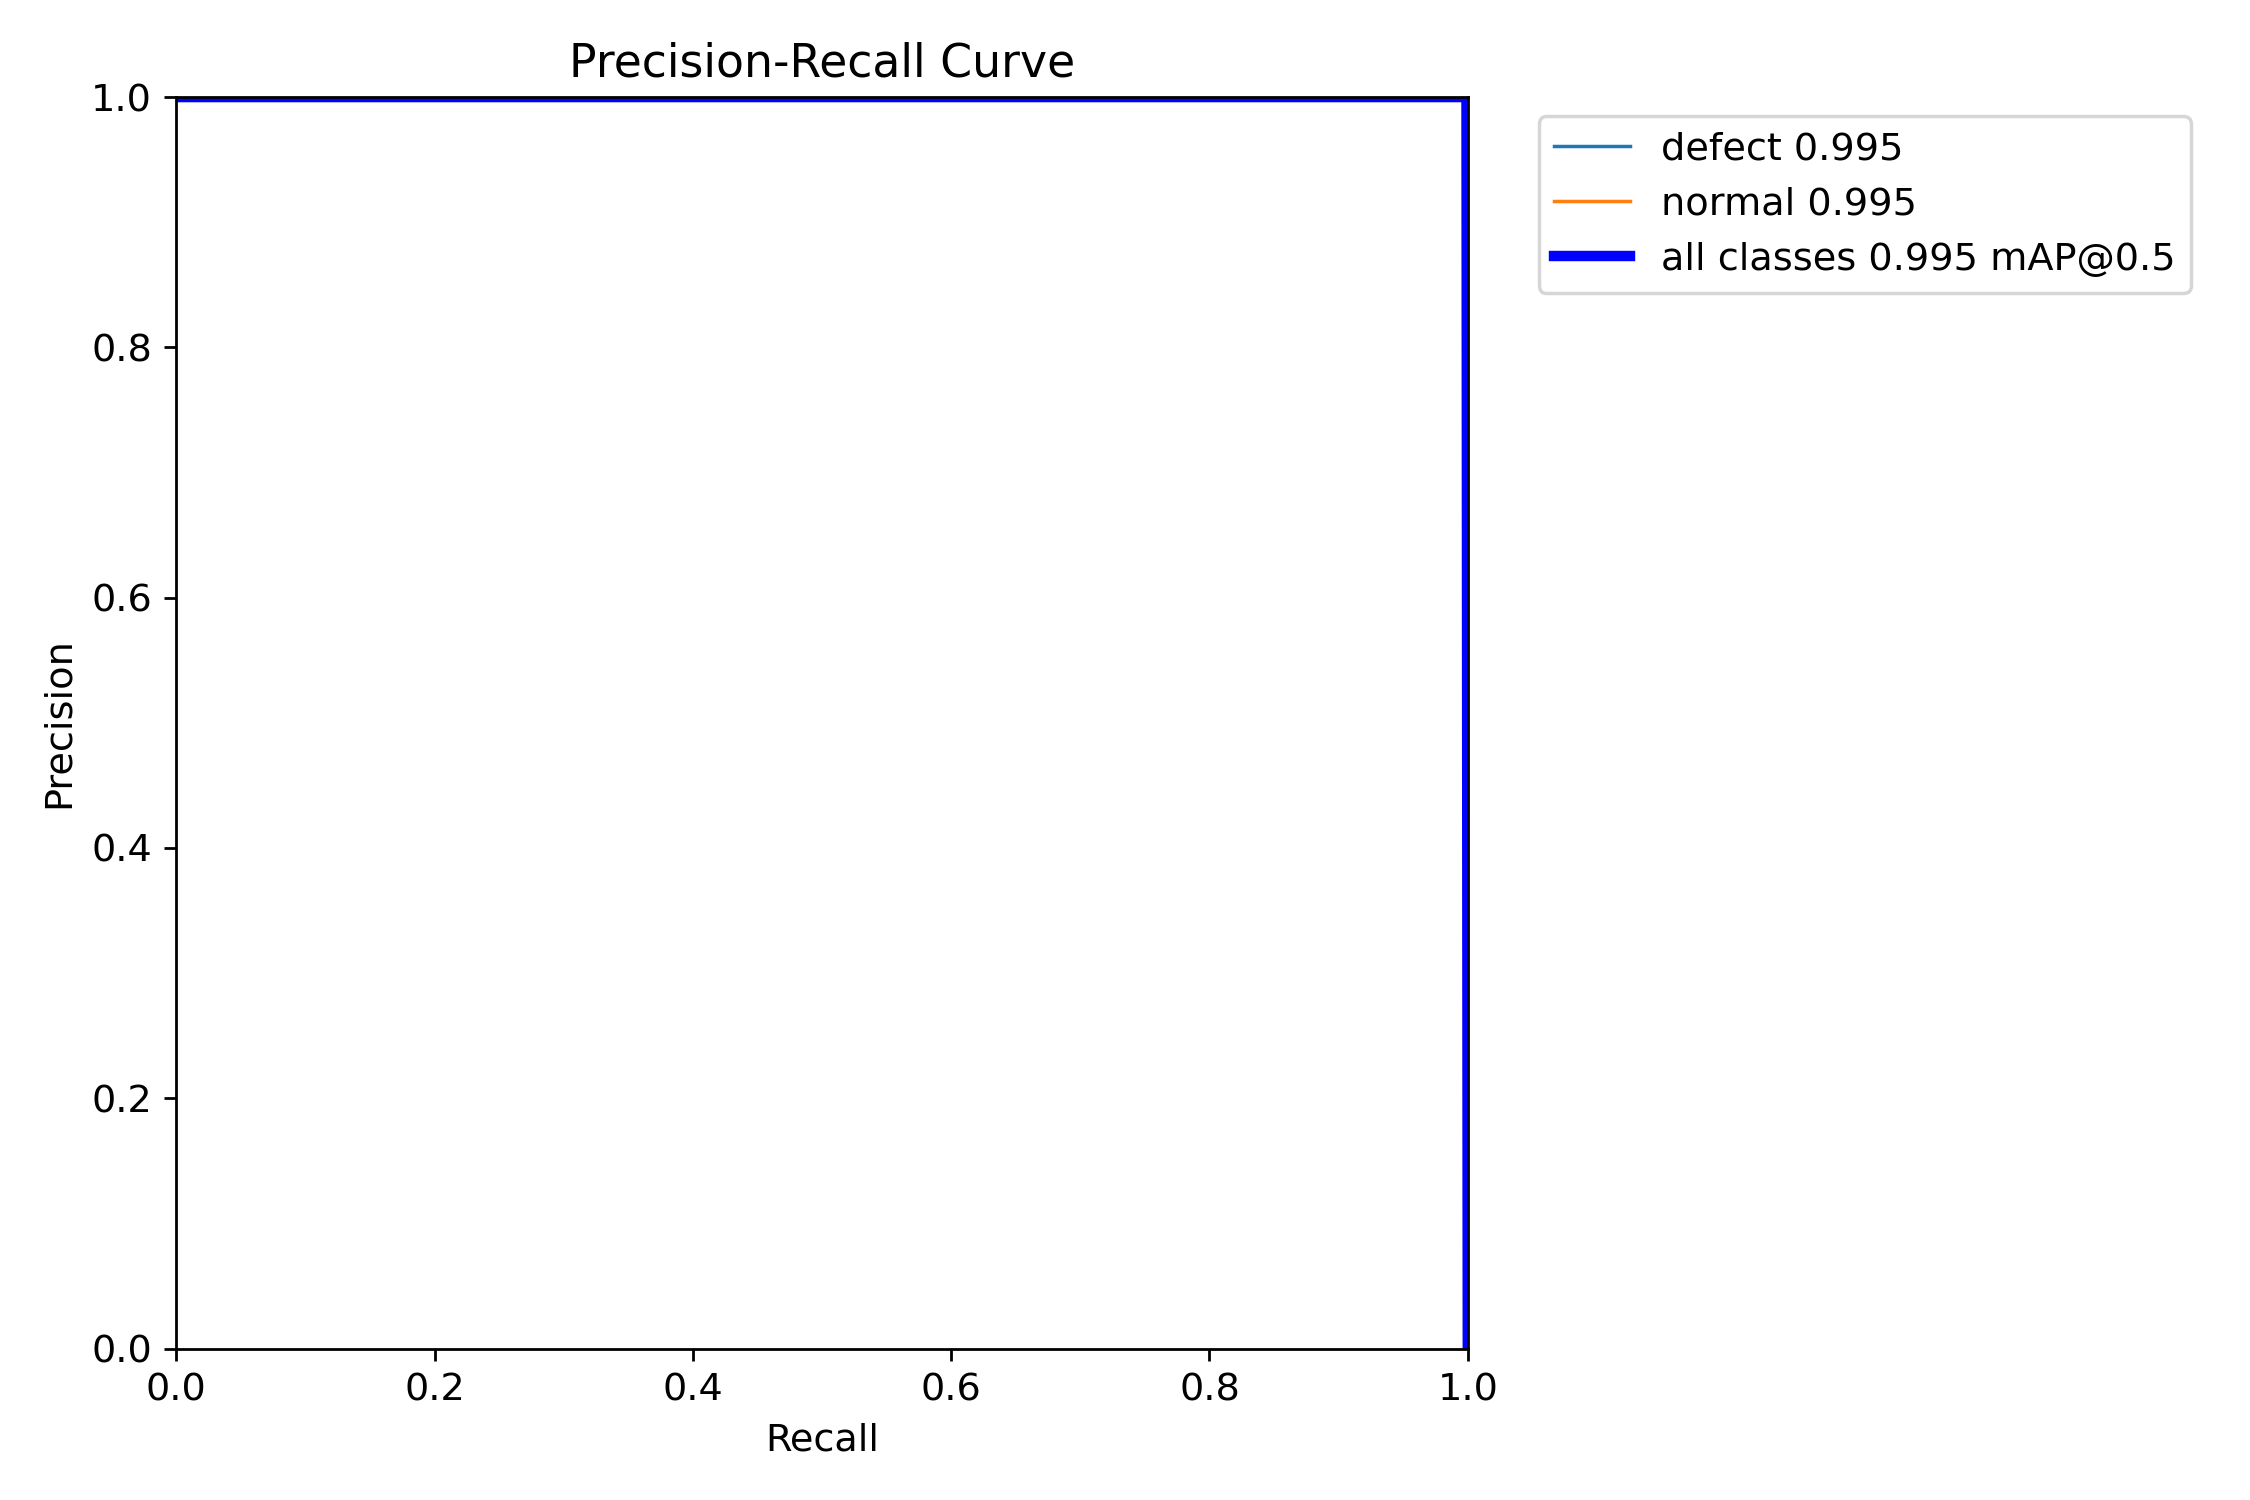

In [27]:
from IPython.display import Image
Image(filename="/content/Pill-Defects/runs/detect/train4/PR_curve.png")


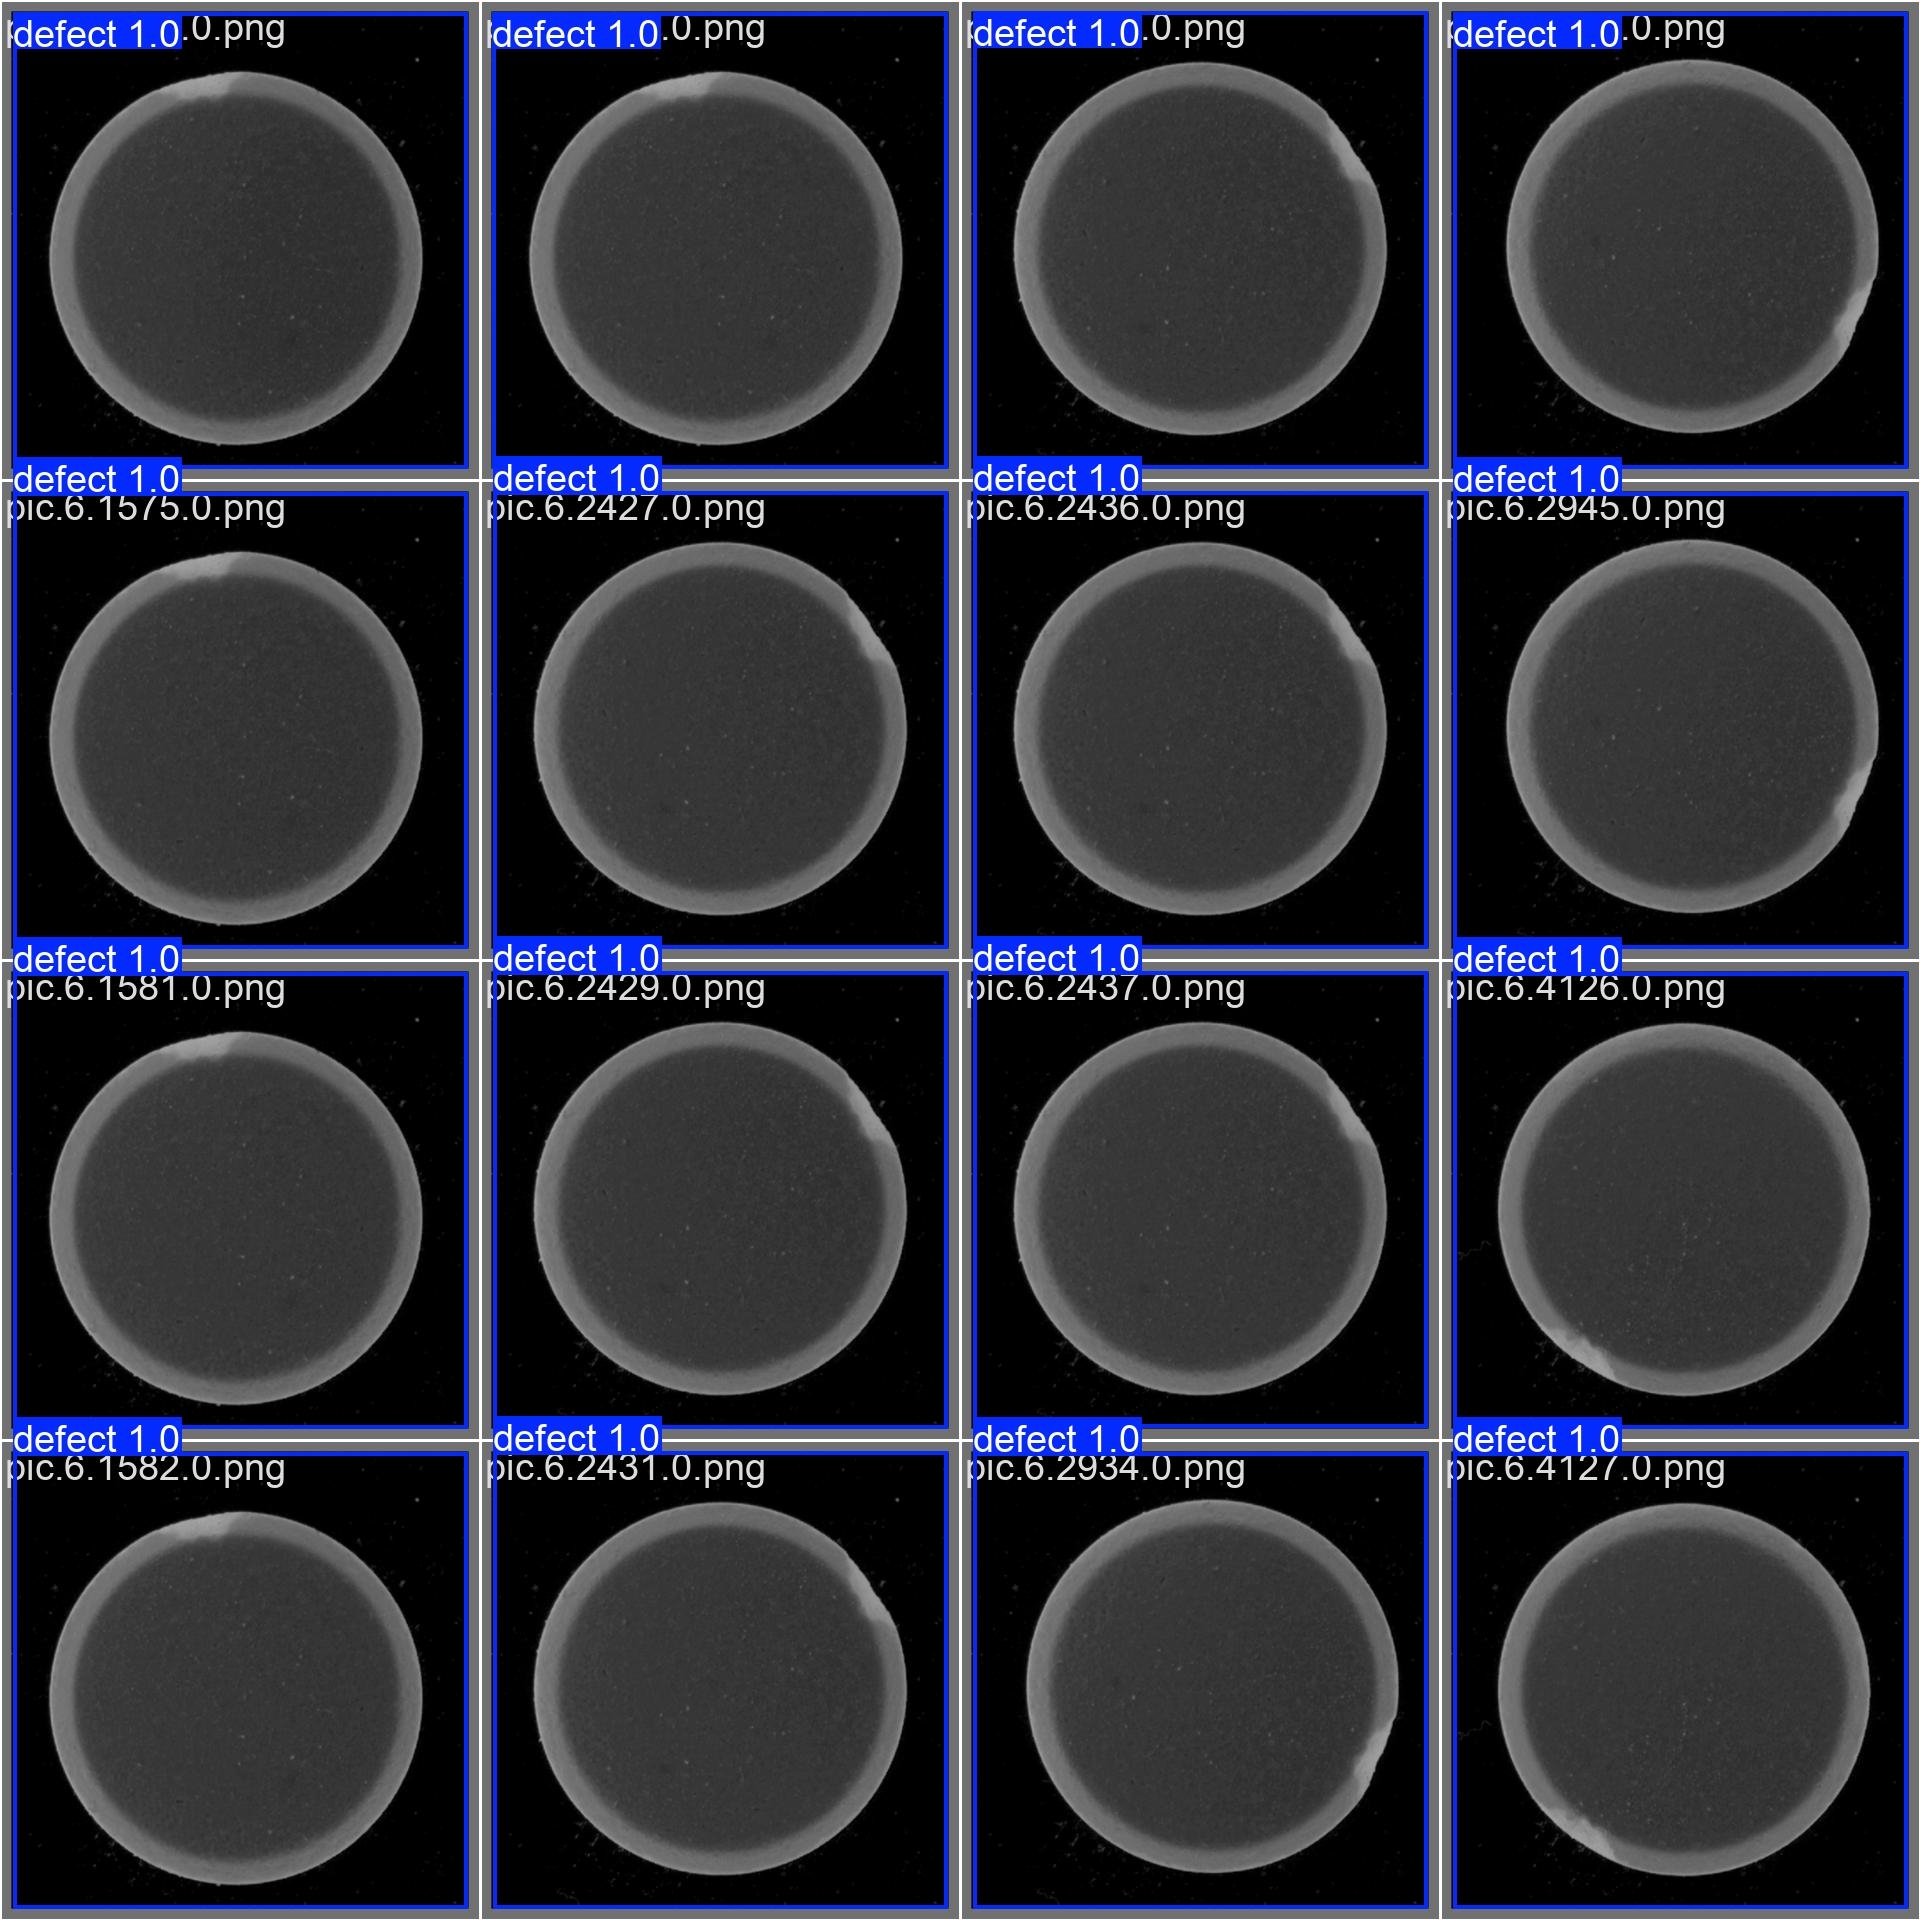

In [28]:
Image(filename="runs/detect/train4/val_batch0_pred.jpg")


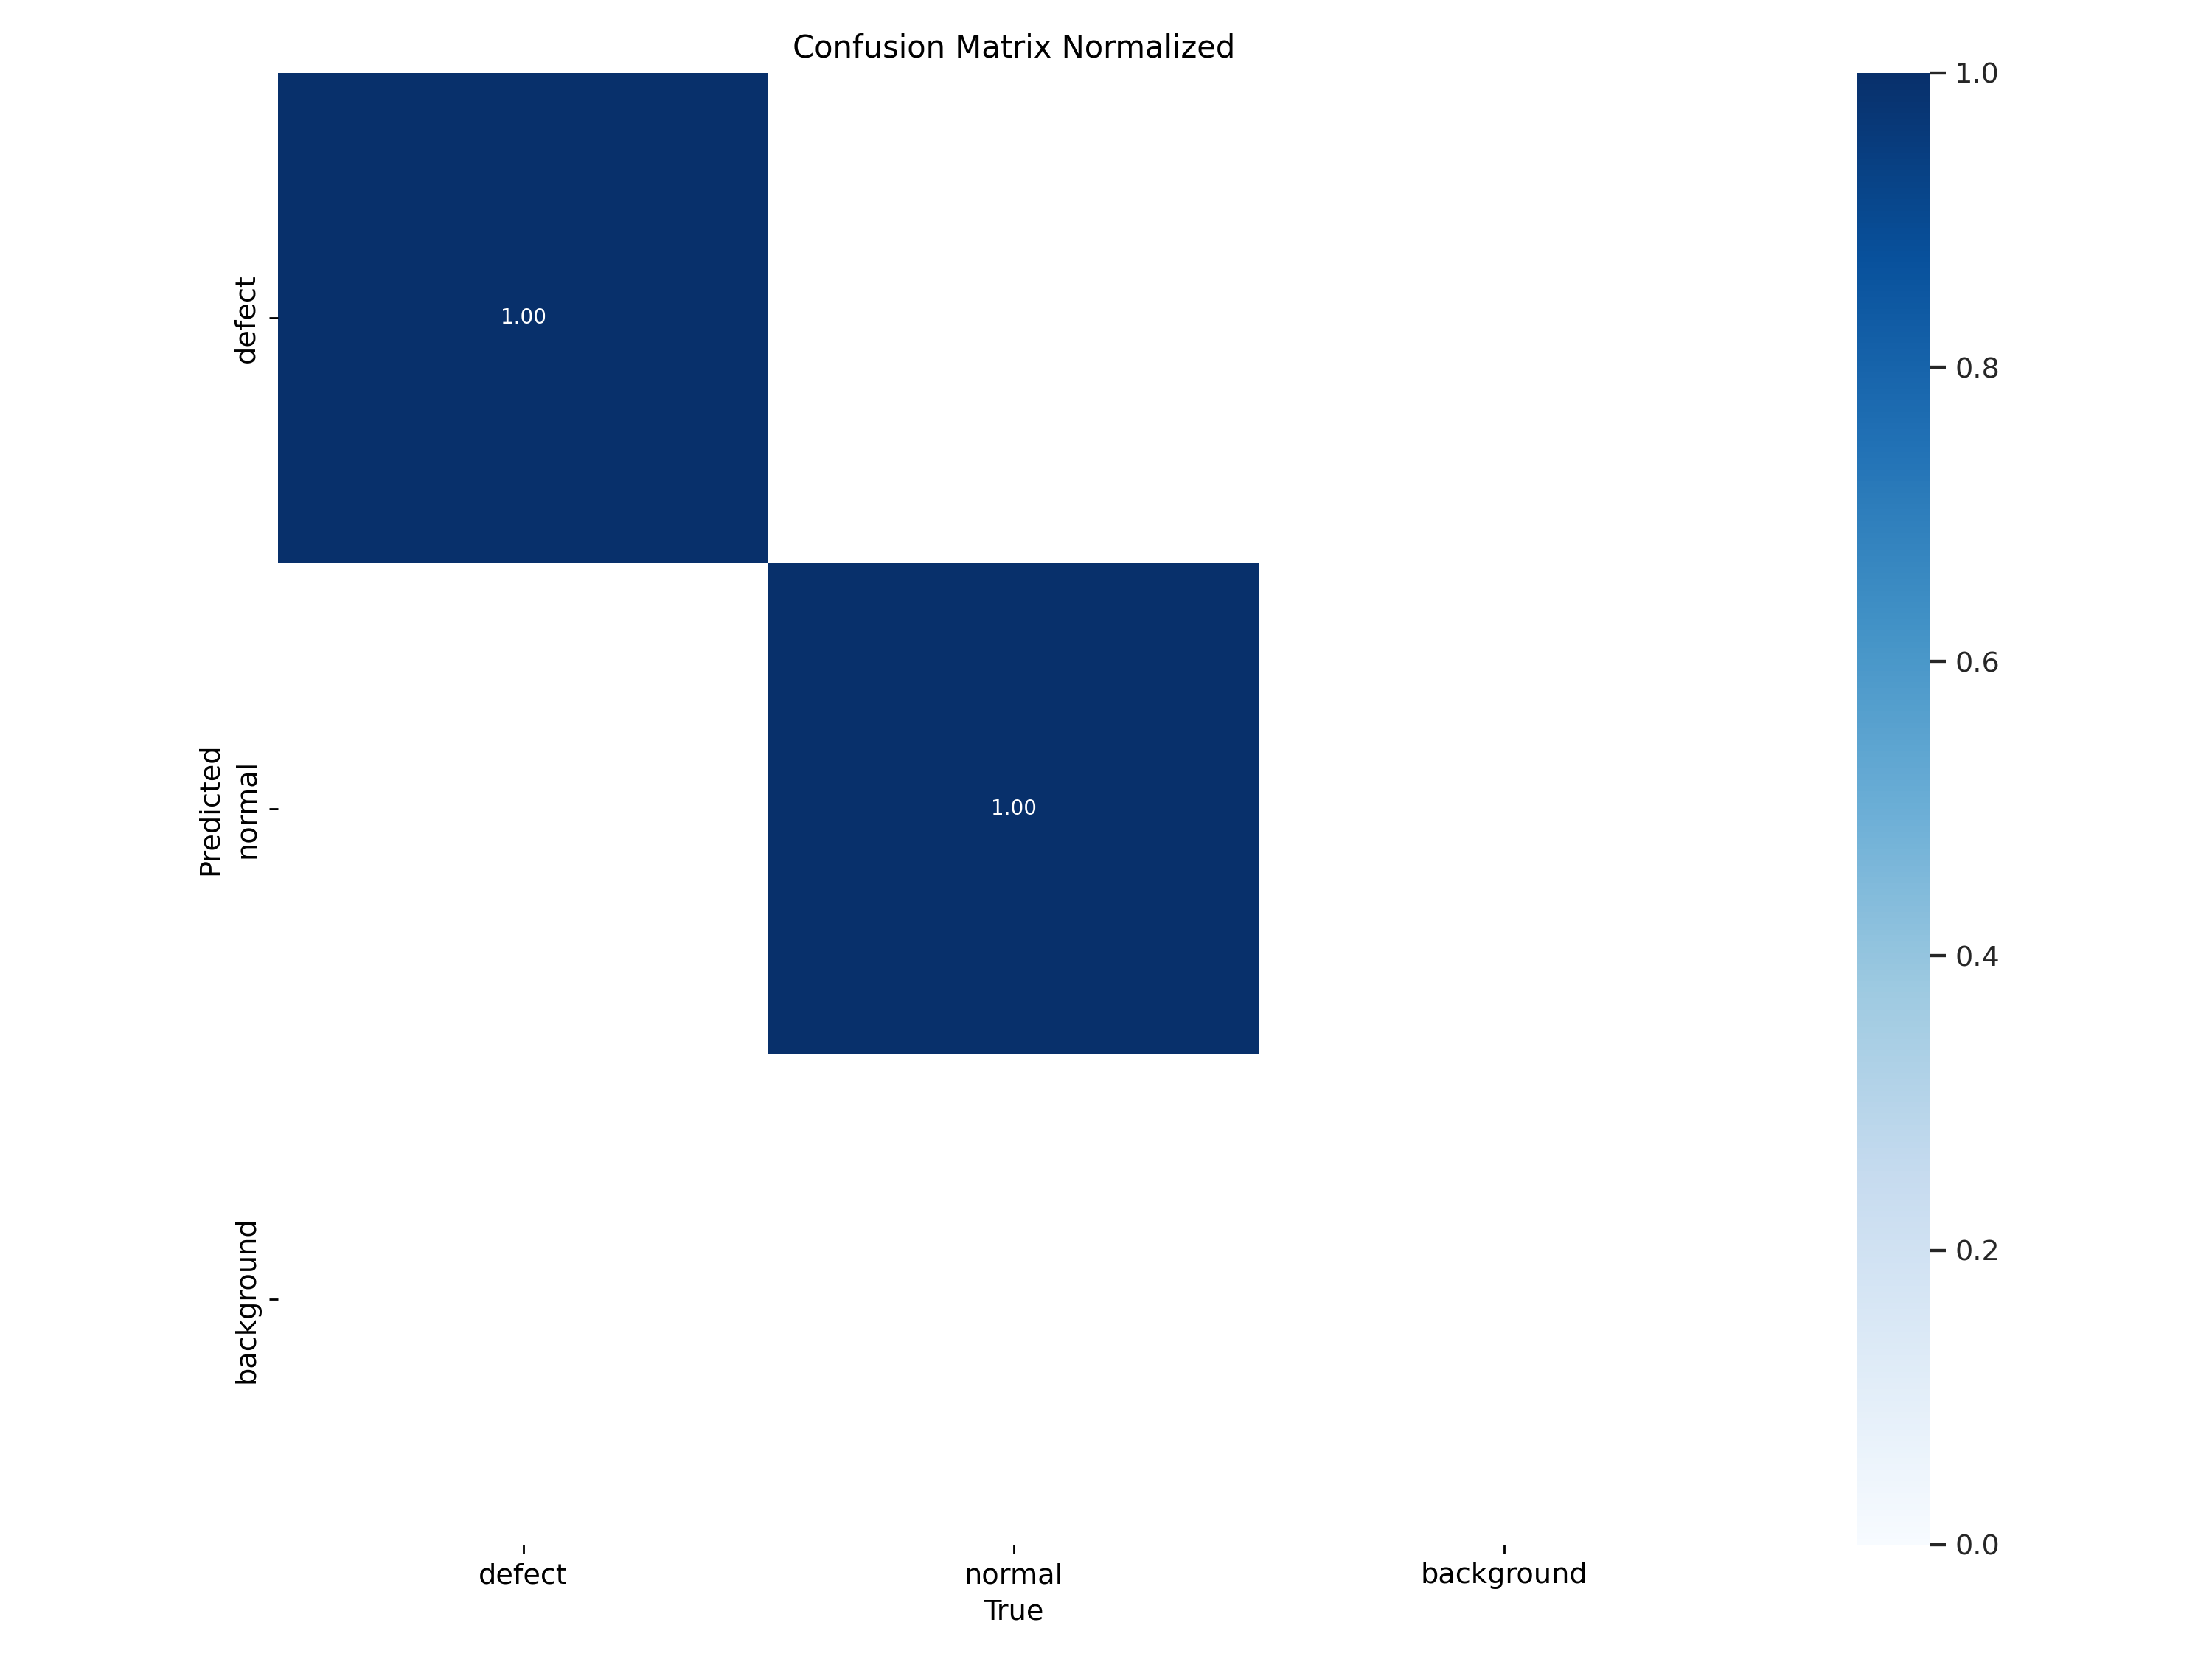

In [29]:
Image(filename="/content/Pill-Defects/runs/detect/train4/confusion_matrix_normalized.png")



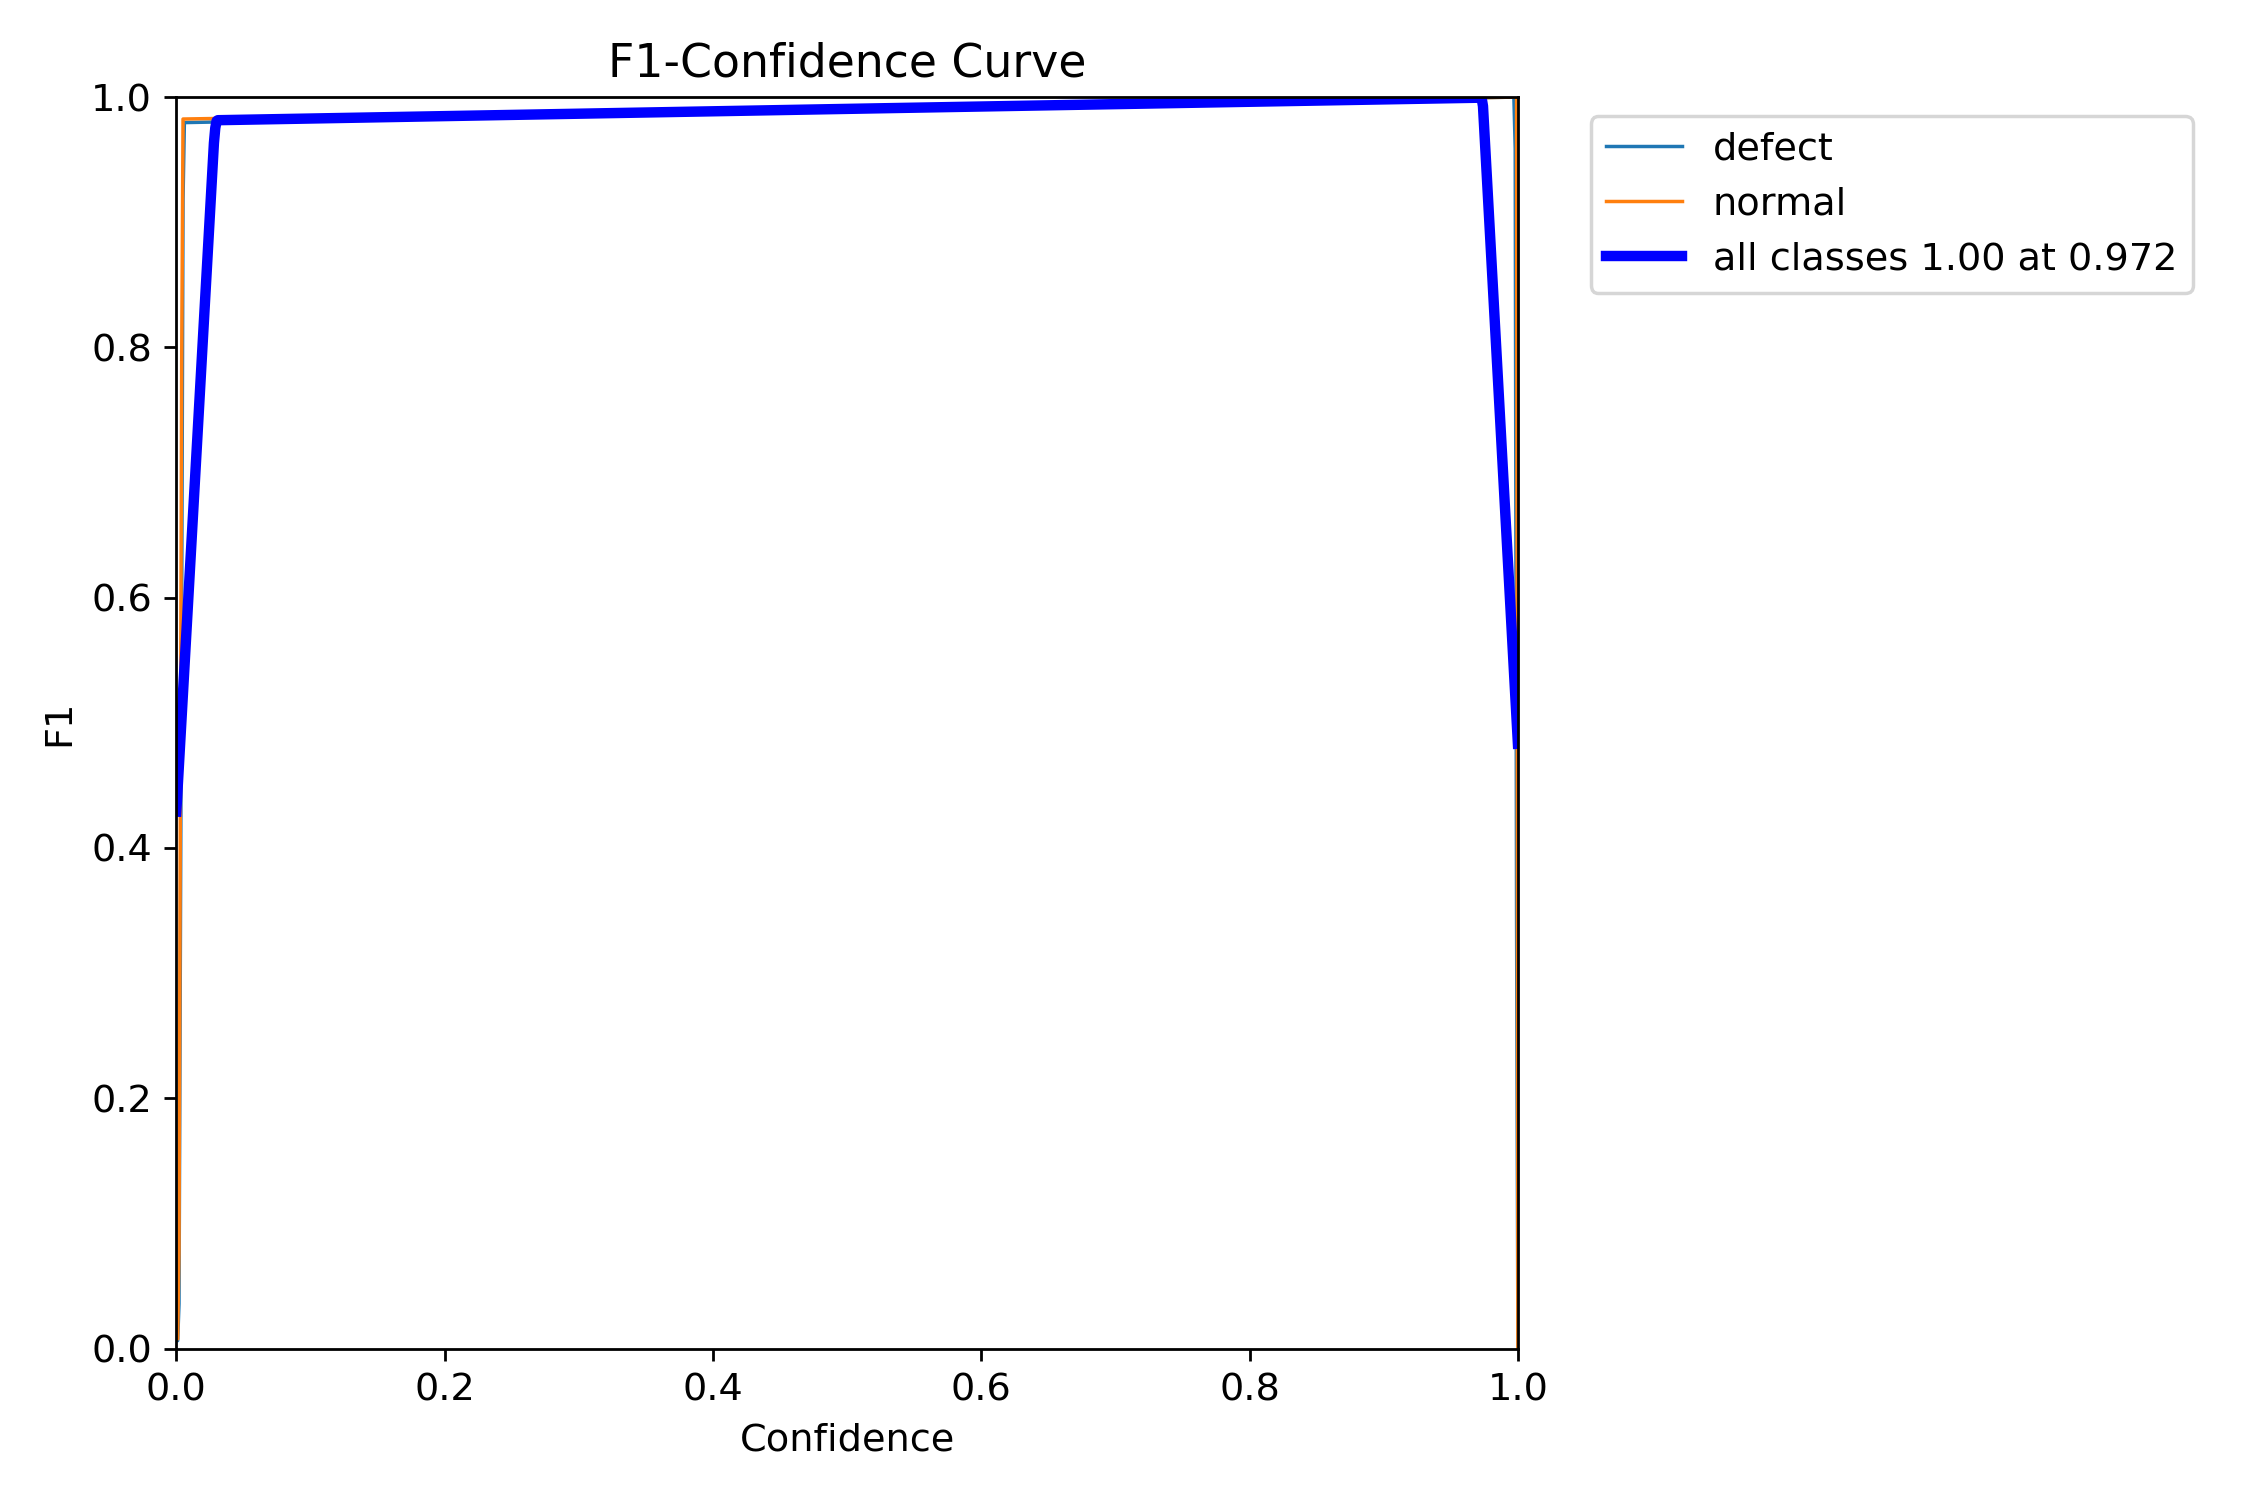

In [30]:
Image(filename="/content/Pill-Defects/runs/detect/train4/F1_curve.png")





In [31]:
from ultralytics import YOLO

# Load the best trained model
model = YOLO("runs/detect/train4/weights/best.pt")  # Update with correct path



image 1/1 /content/Pill-Defects/yolo_dataset/images/val/pic.6.571.0.png: 640x640 1 defect, 9.1ms
Speed: 3.4ms preprocess, 9.1ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


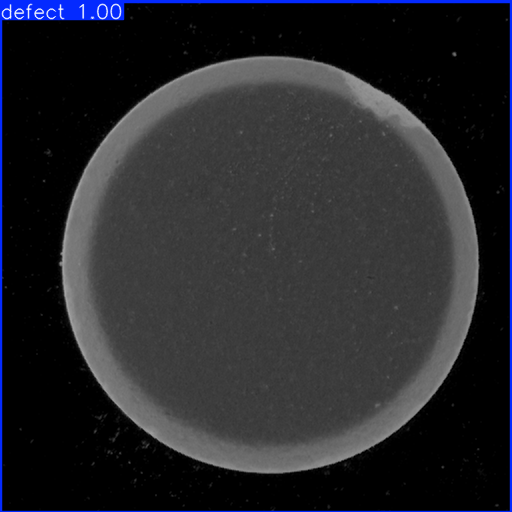

In [36]:

results = model("yolo_dataset/images/val/pic.6.571.0.png")

# Show results
results[0].show()  # Access the first result in the list




In [38]:
# Run inference
results = model("yolo_dataset/images/val/pic.6.571.0.png")

# Save the first result
results[0].save("prediction_result.png")



image 1/1 /content/Pill-Defects/yolo_dataset/images/val/pic.6.571.0.png: 640x640 1 defect, 9.0ms
Speed: 3.7ms preprocess, 9.0ms inference, 1.4ms postprocess per image at shape (1, 3, 640, 640)


'prediction_result.png'

In [40]:
for result in results:
    for box in result.boxes:
        print(f"Class: {box.cls}, Confidence: {box.conf}, BBox: {box.xyxy}")


Class: tensor([0.], device='cuda:0'), Confidence: tensor([0.9967], device='cuda:0'), BBox: tensor([[  0.0000,   1.2754, 511.7540, 512.0000]], device='cuda:0')


In [42]:
from ultralytics import YOLO

# Load the trained YOLOv8 model
model = YOLO("runs/detect/train4/weights/best.pt")  # Update with correct path

# Run inference on an actual validation image
results = model("yolo_dataset/images/val/pic.6.571.0.png")  # Update filename

# Print raw results (check if objects are detected)
print(results)



image 1/1 /content/Pill-Defects/yolo_dataset/images/val/pic.6.571.0.png: 640x640 1 defect, 8.8ms
Speed: 2.9ms preprocess, 8.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)
[ultralytics.engine.results.Results object with attributes:

boxes: ultralytics.engine.results.Boxes object
keypoints: None
masks: None
names: {0: 'defect', 1: 'normal'}
obb: None
orig_img: array([[[0, 0, 0],
        [1, 1, 1],
        [1, 1, 1],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0]

In [43]:
results = model("yolo_dataset/images/val/pic.6.571.0.png", conf=0.1)



image 1/1 /content/Pill-Defects/yolo_dataset/images/val/pic.6.571.0.png: 640x640 1 defect, 9.8ms
Speed: 3.4ms preprocess, 9.8ms inference, 1.3ms postprocess per image at shape (1, 3, 640, 640)


In [45]:
if results and results[0].boxes:
    for box in results[0].boxes:
        print(f"Class: {box.cls}, Confidence: {box.conf}, BBox: {box.xyxy}")
else:
    print(" No objects detected in the image!")


Class: tensor([0.], device='cuda:0'), Confidence: tensor([0.9967], device='cuda:0'), BBox: tensor([[  0.0000,   1.2754, 511.7540, 512.0000]], device='cuda:0')


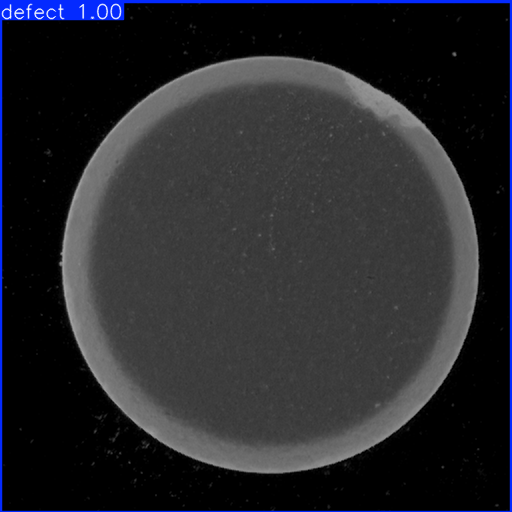

In [46]:
results[0].show()  # Displays image with bounding boxes (useful in local setup)


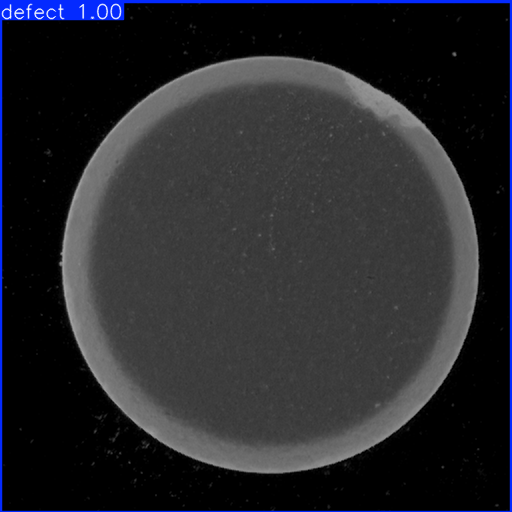

In [47]:
# Save image with predictions
results[0].save("prediction_result.png")

# Display in Google Colab
from IPython.display import display
from PIL import Image

image = Image.open("prediction_result.png")
display(image)


In [50]:
results[0].save("predicted_image.png")  # Saves the image


'predicted_image.png'

In [51]:
from google.colab import files
files.download("predicted_image.png")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [52]:
if results and results[0].boxes:
    for box in results[0].boxes:
        class_id = int(box.cls.cpu().numpy()[0])  # Get class ID
        confidence = float(box.conf.cpu().numpy()[0])  # Get confidence score
        bbox = box.xyxy.cpu().numpy()[0]  # Get bbox [x1, y1, x2, y2]

        print(f"Class: {class_id}, Confidence: {confidence:.2f}, BBox: {bbox}")
else:
    print(" No objects detected in the image!")


Class: 0, Confidence: 1.00, BBox: [          0      1.2754      511.75         512]


In [53]:
metrics = model.val()

# Extract mAP50 and mAP50-95
map_50 = metrics.box.map50  # mAP at IoU=0.5
map_50_95 = metrics.box.map  # mAP at IoU 0.5 to 0.95

print(f"mAP50: {map_50:.4f}")
print(f"mAP50-95: {map_50_95:.4f}")


Ultralytics 8.3.78 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)


val: Scanning /content/Pill-Defects/yolo_dataset/labels/val.cache... 52 images, 0 backgrounds, 0 corrupt: 100%|██████████| 52/52 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:03<00:00,  1.32it/s]


                   all         52         52      0.998          1      0.995      0.995
                defect         24         24      0.998          1      0.995      0.995
                normal         28         28      0.998          1      0.995      0.995
Speed: 16.2ms preprocess, 6.5ms inference, 0.0ms loss, 3.3ms postprocess per image
Results saved to runs/detect/val
mAP50: 0.9950
mAP50-95: 0.9950
